## Inductive and Deductive Inference to Understand Autoantibody–Proteomic Interactions in SLE Using Knowledge Graphs

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [98]:
# read data
aca_data = pd.read_csv('data/aca_data.csv')
proteomic_data = pd.read_csv('data/proteomic_data.csv')
proteomic_module_data = pd.read_csv('data/proteomic_module_data.csv')
sledai_data = pd.read_csv('data/sledai_data.csv')

In [99]:
# rename person_id column to PMBBID in all dataframes
aca_data.rename(columns={'person_id': 'PMBBID'}, inplace=True)
proteomic_data.rename(columns={'person_id': 'PMBBID'}, inplace=True)
proteomic_module_data.rename(columns={'person_id': 'PMBBID'}, inplace=True)
sledai_data.rename(columns={'person_id': 'PMBBID'}, inplace=True)

In [100]:
# merge data
merged_data = aca_data.merge(proteomic_module_data, on='PMBBID')
merged_data = merged_data.merge(sledai_data, on='PMBBID')
# binarize SLEDAI column: 1 if SLEDAI >= 4 else 0  - this represents active vs inactive disease
merged_data['SLEDAI_binarized'] = merged_data['SLEDAI'].apply(lambda x: 1 if x >= 4 else 0)

In [101]:
# print basic info about merged data
print("Merged Data Info:")
print(f"Number of samples: {merged_data.shape[0]}")
print(f"Sex distribution {merged_data['sex'].value_counts(normalize=True).to_dict()}")
print(f"Age distribution: Mean={merged_data['age'].mean()}, Std={merged_data['age'].std()}")

Merged Data Info:
Number of samples: 180
Sex distribution {'Female': 0.8611111111111112, 'Male': 0.1388888888888889}
Age distribution: Mean=45.827777777777776, Std=15.347014178534907


In [102]:
# features of interest
module_cols = [c for c in merged_data.columns if c.startswith("ME")]
aca_cols = ['ACA.IFNALPHA',
    'ACA.IL15',
    'ACA.IL31',
    'ACA.LIF',
    'ACA.MIP',
    'ACA.IFNTWOLAMDA',
    'ACA.GMCSF',
    'ACA.IFNEPSILON',
    'ACA.TNFBETA',
    'ACA.IL22',
    'ACA.CT',
    'ACA.IL6',
    'ACA.IL11',
    'ACA.IL1ALPHA',
    'ACA.SRANK',
    'ACA.IL17A',
    'ACA.IL33',
    'ACA.IL7',
    'ACA.IL17F',
    'ACA.OSM',
    'ACA.TNFALPHA',
    'ACA.PDGFBB',
    'ACA.VEGFB',
    'ACA.IFNONELAMDA',
    'ACA.IL1BETA',
    'ACA.IL10',
    'ACA.IFNGAMMA',
    'ACA.IL12',
    'ACA.CCL11',
    'ACA.CCL24',
    'ACA.TRIM33',
    'ACA.IL27',
    'ACA.CNTF',
    'ACA.CD74',
    'ACA.IFNBETA',
    'ACA.IFNTHREELAMDA',
    'ACA.ACE2',
    'ACA.IL12P40',
    'ACA.IFNOMEGA']
input_features = module_cols + ['age'] + aca_cols 
target_variable = 'SLEDAI_binarized'

In [103]:
print(f"# Total Input features: {len(input_features)}")
print(f"# ACA features: {len(aca_cols)}")
print(f"# Module features: {len(module_cols)}")

# Total Input features: 48
# ACA features: 39
# Module features: 8


In [104]:
MODEL_RESULTS = {} # to store results of different models

### Inductive Classifier

In [105]:
data_model = merged_data[['PMBBID'] + input_features + [target_variable]]

In [106]:
# train test split
train_data, test_data = train_test_split(data_model, test_size=0.2, random_state=42)
print(f"Train samples: {train_data.shape[0]}, Test samples: {test_data.shape[0]}")


Train samples: 144, Test samples: 36


In [107]:
# train a random forest classifier on ALL features

X_train = train_data[input_features]
y_train = train_data[target_variable]

X_test = test_data[input_features]
y_test = test_data[target_variable]

rf_classifier = RandomForestClassifier(n_estimators=5, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# print accuracy
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:.2f}')

# print F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1:.2f}')

# print AUC
y_prob = rf_classifier.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC: {auc_score:.2f}')

MODEL_RESULTS['RandomForest_ALL_Features'] = {'f1_score': f1}

Accuracy: 0.72
F1-score: 0.64
AUC: 0.71


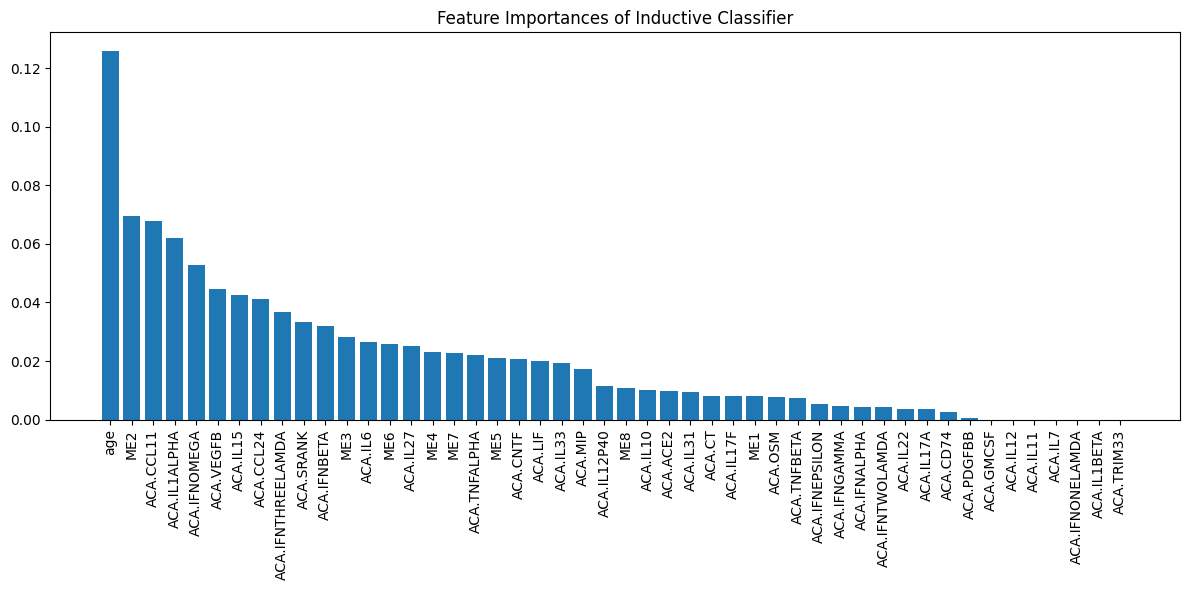

In [108]:
# show plot of feature importances
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances of Inductive Classifier")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [input_features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig('plots/feature_importances.png')
plt.show()


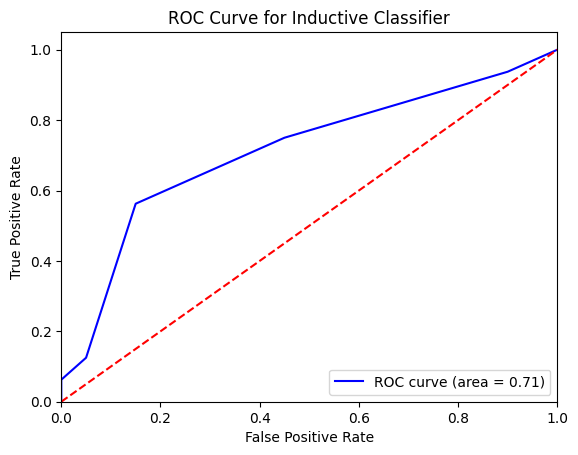

In [109]:
# plot AUC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Inductive Classifier')
plt.legend(loc="lower right")
plt.savefig('plots/roc_curve_inductive_classifier.png')
plt.show()

In [110]:
# train a random forest classifier on only ACA features
X_train_aca = train_data[aca_cols]
y_train_aca = train_data[target_variable]

X_test_aca = test_data[aca_cols]
y_test_aca = test_data[target_variable]

rf_classifier_aca = RandomForestClassifier(n_estimators=5, random_state=42)
rf_classifier_aca.fit(X_train_aca, y_train_aca)
y_pred_aca = rf_classifier_aca.predict(X_test_aca)
# print accuracy
accuracy_aca = np.mean(y_pred_aca == y_test_aca)
print(f'Accuracy (ACA only): {accuracy_aca:.2f}')
# print F1-score
f1_aca = f1_score(y_test_aca, y_pred_aca)
print(f'F1-score (ACA only): {f1_aca:.2f}')
# print AUC
y_prob_aca = rf_classifier_aca.predict_proba(X_test_aca)[:, 1]
auc_score_aca = roc_auc_score(y_test_aca, y_prob_aca)
print(f'AUC (ACA only): {auc_score_aca:.2f}')

MODEL_RESULTS['RandomForest_ACA_Only'] = {'f1_score': f1_aca}


Accuracy (ACA only): 0.53
F1-score (ACA only): 0.19
AUC (ACA only): 0.55


### Deductive Classifier

In [111]:
print(f"Module columns: {module_cols}")
print(f"ACA columns: {aca_cols}")
deductive_data = merged_data.copy()
# filter to PMBBIDs in train_data
deductive_data_train = deductive_data[deductive_data['PMBBID'].isin(train_data['PMBBID'])]
deductive_data_test = deductive_data[deductive_data['PMBBID'].isin(test_data['PMBBID'])]

Module columns: ['ME1', 'ME2', 'ME3', 'ME4', 'ME5', 'ME6', 'ME7', 'ME8']
ACA columns: ['ACA.IFNALPHA', 'ACA.IL15', 'ACA.IL31', 'ACA.LIF', 'ACA.MIP', 'ACA.IFNTWOLAMDA', 'ACA.GMCSF', 'ACA.IFNEPSILON', 'ACA.TNFBETA', 'ACA.IL22', 'ACA.CT', 'ACA.IL6', 'ACA.IL11', 'ACA.IL1ALPHA', 'ACA.SRANK', 'ACA.IL17A', 'ACA.IL33', 'ACA.IL7', 'ACA.IL17F', 'ACA.OSM', 'ACA.TNFALPHA', 'ACA.PDGFBB', 'ACA.VEGFB', 'ACA.IFNONELAMDA', 'ACA.IL1BETA', 'ACA.IL10', 'ACA.IFNGAMMA', 'ACA.IL12', 'ACA.CCL11', 'ACA.CCL24', 'ACA.TRIM33', 'ACA.IL27', 'ACA.CNTF', 'ACA.CD74', 'ACA.IFNBETA', 'ACA.IFNTHREELAMDA', 'ACA.ACE2', 'ACA.IL12P40', 'ACA.IFNOMEGA']


In [112]:
def write_rules(rules, filename='deductive_rules.txt'):
    with open(filename, 'w') as f:
        for rule in rules:
            direction1 = "LOW"
            direction2 = "LOW" if rule['stat'] > 0 else "HIGH"
            f.write(f"{direction1} {rule['Var1']} => {direction2} {rule['Var2']}\n")
            f.write(f"{direction1} {rule['Var2']} => {direction2} {rule['Var1']}\n")
            direction1 = "HIGH"
            direction2 = "HIGH" if rule['stat'] > 0 else "LOW"
            f.write(f"{direction1} {rule['Var1']} => {direction2} {rule['Var2']}\n")
            f.write(f"{direction1} {rule['Var2']} => {direction2} {rule['Var1']}\n")


In [113]:
## we will now create rules by calculating correlations between ACAs and modules
from scipy.stats import spearmanr
correlation_results = []
for aca in aca_cols:
    for mod in module_cols:
        # calculate Spearman correlation
        spearman_corr, spearman_pval = spearmanr(deductive_data_train[aca], deductive_data_train[mod])
        # store results
        correlation_results.append({
            'Var1': aca,
            'Var2': mod,
            'stat': spearman_corr,
            'p-value': spearman_pval
        })

# filter for significant correlations (p < 0.01)
significant_correlations = [res for res in correlation_results if res['p-value'] < 0.05]
print(f"Found {len(significant_correlations)} significant correlations between ACAs and Modules.")

# save as latex table
correlation_df = pd.DataFrame(significant_correlations)
# rename columns for better latex display
correlation_df.rename(columns={'Var1': 'ACA', 'Var2': 'Module', 'stat': 'Spearman Correlation', 'p-value': 'P Value'}, inplace=True)
correlation_df.to_latex('tables/significant_aca_module_correlations.tex', index=False)

# save as rules
write_rules(significant_correlations, filename='rules/deductive_rules_aca_module.rules.txt')

Found 27 significant correlations between ACAs and Modules.


In [114]:
## we will now create rules by calculating correlations within modules
from scipy.stats import spearmanr
correlation_results = []
for i, mod1 in enumerate(module_cols):
    for mod2 in module_cols[i+1:]:
        # calculate Spearman correlation
        spearman_corr, spearman_pval = spearmanr(deductive_data_train[mod1], deductive_data_train[mod2])
        # store results
        correlation_results.append({
            'Var1': mod1,
            'Var2': mod2,
            'stat': spearman_corr,
            'p-value': spearman_pval
        })

# filter for significant correlations (p < 0.01)
significant_correlations = [res for res in correlation_results if res['p-value'] < 0.05]
print(f"Found {len(significant_correlations)} significant correlations between ACAs and Modules.")

# save as latex table
correlation_df = pd.DataFrame(significant_correlations)
# rename columns for better latex display
correlation_df.rename(columns={'Var1': 'Module 1', 'Var2': 'Module 2', 'stat': 'Spearman Correlation', 'p-value': 'P Value'}, inplace=True)
correlation_df.to_latex('tables/significant_module_module_correlations.tex', index=False)

# save as rules
write_rules(significant_correlations, filename='rules/deductive_rules_module_module.rules.txt')

Found 20 significant correlations between ACAs and Modules.


In [115]:
## we will now create rules by finding significant t-test differences between high and low SLEDAI groups
t_test_results = []
from scipy.stats import ttest_ind
high_sledai = deductive_data_train[deductive_data_train['SLEDAI_binarized'] == 1]
low_sledai = deductive_data_train[deductive_data_train['SLEDAI_binarized'] == 0]
for module in module_cols:
    t_stat, p_val = ttest_ind(high_sledai[module], low_sledai[module], equal_var=False)
    t_test_results.append({
        'Var1': module,
        'Var2': 'SLEDAI_binarized',
        'stat': t_stat,
        'p-value': p_val
    })
# filter for significant results (p < 0.01)
significant_t_tests = [res for res in t_test_results if res['p-value'] < 0.05]
print(f"Found {len(significant_t_tests)} significant t-test results between Modules and SLEDAI.")

# save as latex table
correlation_df = pd.DataFrame(significant_t_tests)
# rename columns for better latex display
correlation_df.rename(columns={'Var1': 'Module', 'Var2': 'SLEDAI', 'stat': 'T-statistic', 'p-value': 'P Value'}, inplace=True)
correlation_df.to_latex('tables/significant_module_SLEDAI.tex', index=False)

# save as rules
write_rules(significant_t_tests, filename='rules/deductive_rules_module_sledai.rules.txt')

Found 1 significant t-test results between Modules and SLEDAI.


In [116]:
def discretize_data(data, cutoffs, cols):
    data_disc = data.copy()
    for col in cols:
        quantile_low, quantile_high = cutoffs[col]
        data_disc[col + "_disc"] = pd.cut(data[col],
                                          bins=[-np.inf, quantile_low, quantile_high, np.inf],
                                          labels=["LOW", "MED", "HIGH"])
    return data_disc
def load_rules(filename):
    rules = []
    with open(filename, 'r') as f:
        for line in f:
            # Expected format: LOW Var1 => HIGH Var2
            parts = line.strip().split(' ')
            rules.append({
                'IF_Level': parts[0],
                'IF_Var': parts[1],
                'THEN_Level': parts[3],
                'THEN_Var': parts[4]
            })
    return rules

In [117]:
all_rules = []
all_rules.extend(load_rules('rules/deductive_rules_aca_module.rules.txt'))
all_rules.extend(load_rules('rules/deductive_rules_module_module.rules.txt'))
all_rules.extend(load_rules('rules/deductive_rules_module_sledai.rules.txt'))

In [118]:
def apply_forward_chaining(patient_data, knowledge_base, initial_facts_vars, verbose=False):
    # initialize known facts
    known_facts = {}
    for var in initial_facts_vars:
        disc_col = var + "_disc"
        if disc_col in patient_data:
            known_facts[var] = patient_data[disc_col]
    if verbose:
        print(f"Initial known facts: {known_facts}")
    
    # forward chaining
    new_fact_deduced = True
    while new_fact_deduced:
        new_fact_deduced = False
        
        for rule in knowledge_base:
            if_var = rule['IF_Var']
            if_level = rule['IF_Level']
            then_var = rule['THEN_Var']
            then_level = rule['THEN_Level']

            # check IF premise is known
            if if_var in known_facts and known_facts[if_var] == if_level:
                # check THEN is already known
                if then_var not in known_facts:
                    # add new fact
                    known_facts[then_var] = then_level
                    new_fact_deduced = True
                    
                    # if we reach SLEDAI value then stop
                    if then_var == 'SLEDAI_binarized':
                        return known_facts.get('SLEDAI_binarized', 'UNKNOWN'), known_facts
    
    return known_facts.get('SLEDAI_binarized', 'UNKNOWN'), known_facts

In [119]:
aca_sample = aca_cols
module_sample = module_cols[:3] 
initial_vars_for_inference = aca_sample 

predictions = []

deductive_data_test_disc = discretize_data(deductive_data_test, 
                                      cutoffs={col: (deductive_data_train[col].quantile(0.33),
                                                     deductive_data_train[col].quantile(0.67)) for col in aca_sample + module_sample},
                                      cols=aca_sample + module_sample)

# run forward chaining on test set
for idx, row in deductive_data_test_disc.iterrows():
    
    sledai_pred, deduced_facts = apply_forward_chaining(
        patient_data=row,
        knowledge_base=all_rules,
        initial_facts_vars=initial_vars_for_inference
    )
    
    # map Predicted_SLEDAI HIGH -> 1, LOW --> 0, UNKNOWN --> 'UNKNOWN'
    sledai_pred = 1 if sledai_pred == 'HIGH' else 0 if sledai_pred == 'LOW' else 'UNKNOWN'

    predictions.append({
        'PMBBID': row['PMBBID'],
        'True_SLEDAI': row['SLEDAI_binarized'],
        'Predicted_SLEDAI': sledai_pred,
        'Deduced_Fact_Count': len(deduced_facts) - len(initial_vars_for_inference),
        'Initial_Facts_Used': [f"{v}: {deduced_facts[v]}" for v in initial_vars_for_inference if v in deduced_facts]
    })


predictions_df = pd.DataFrame(predictions)
# print accuracy
valid_preds = predictions_df[predictions_df['Predicted_SLEDAI'] != 'UNKNOWN']
accuracy = np.mean(valid_preds['Predicted_SLEDAI'] == valid_preds['True_SLEDAI'])
print(f'Accuracy of Deductive Inference: {accuracy:.2f}')

# f1 score
from sklearn.metrics import f1_score
f1 = f1_score(valid_preds['True_SLEDAI'], valid_preds['Predicted_SLEDAI'])
print(f'F1-score of Deductive Inference: {f1:.2f}')

MODEL_RESULTS['Deductive_Inference'] = {'f1_score': f1}

Accuracy of Deductive Inference: 0.56
F1-score of Deductive Inference: 0.60


In [120]:
# assess relationship between number of initial facts used and accuracy
def run_deductive_inference(n_facts):
    # randomly select n_facts from aca_sample
    np.random.seed(20)
    initial_vars_for_inference = np.random.choice(aca_sample, size=n_facts, replace=False).tolist()

    predictions = []

    deductive_data_test_disc = discretize_data(deductive_data_test, 
                                       cutoffs={col: (deductive_data_train[col].quantile(0.33),
                                                      deductive_data_train[col].quantile(0.67)) for col in aca_sample + module_sample},
                                       cols=aca_sample + module_sample)

    # run forward chaining on test set
    for idx, row in deductive_data_test_disc.iterrows():
        
        sledai_pred, deduced_facts = apply_forward_chaining(
            patient_data=row,
            knowledge_base=all_rules,
            initial_facts_vars=initial_vars_for_inference
        )
        
        sledai_pred = 1 if sledai_pred == 'HIGH' else 0 if sledai_pred == 'LOW' else 'UNKNOWN'

        predictions.append({
            'PMBBID': row['PMBBID'],
            'True_SLEDAI': row['SLEDAI_binarized'],
            'Predicted_SLEDAI': sledai_pred,
            'Deduced_Fact_Count': len(deduced_facts) - len(initial_vars_for_inference),
            'Initial_Facts_Used': [f"{v}: {deduced_facts[v]}" for v in initial_vars_for_inference if v in deduced_facts]
        })

    predictions_df = pd.DataFrame(predictions)
    
    # calculate accuracy ignoring UNKNOWN predictions
    valid_preds = predictions_df[predictions_df['Predicted_SLEDAI'] != 'UNKNOWN']
    if len(valid_preds) == 0:
        f1_score_value = 0.0
        return f1_score_value, len(predictions_df)
    preds = valid_preds['Predicted_SLEDAI'].astype(int)
    truths = valid_preds['True_SLEDAI'].astype(int)
    f1_score_value = f1_score(truths, preds)
    # number of unknown predictions
    n_unknown = int(len(predictions_df) - len(valid_preds))
    return f1_score_value, n_unknown


In [121]:
n_initial_facts_results = []
for n_facts in range(1, len(aca_sample) + 1):
    f1, n_unk = run_deductive_inference(n_facts)
    print(f"Using {n_facts} initial facts: Accuracy = {f1:.2f}, Unknown Predictions = {n_unk}")
    n_initial_facts_results.append({
        'n_initial_facts': n_facts,
        'f1_score': f1,
        'n_unknown_predictions': n_unk
    })

Using 1 initial facts: Accuracy = 0.00, Unknown Predictions = 36
Using 2 initial facts: Accuracy = 0.00, Unknown Predictions = 36
Using 3 initial facts: Accuracy = 0.53, Unknown Predictions = 18
Using 4 initial facts: Accuracy = 0.52, Unknown Predictions = 10
Using 5 initial facts: Accuracy = 0.52, Unknown Predictions = 10
Using 6 initial facts: Accuracy = 0.52, Unknown Predictions = 10
Using 7 initial facts: Accuracy = 0.52, Unknown Predictions = 10
Using 8 initial facts: Accuracy = 0.52, Unknown Predictions = 10
Using 9 initial facts: Accuracy = 0.50, Unknown Predictions = 3
Using 10 initial facts: Accuracy = 0.58, Unknown Predictions = 1
Using 11 initial facts: Accuracy = 0.58, Unknown Predictions = 1
Using 12 initial facts: Accuracy = 0.58, Unknown Predictions = 1
Using 13 initial facts: Accuracy = 0.59, Unknown Predictions = 1
Using 14 initial facts: Accuracy = 0.59, Unknown Predictions = 1
Using 15 initial facts: Accuracy = 0.62, Unknown Predictions = 0
Using 16 initial facts: Ac

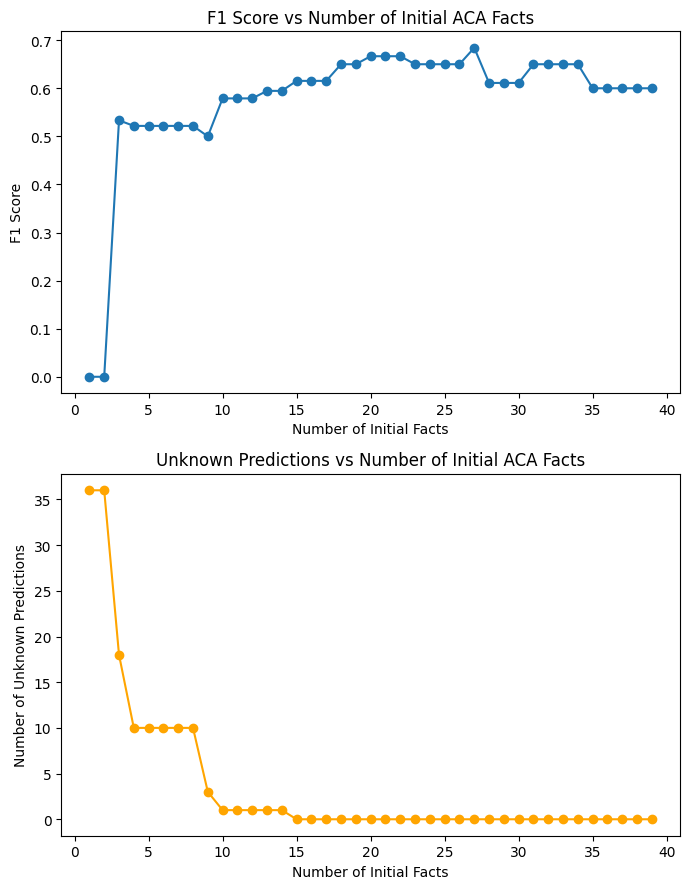

In [122]:
# plot results
results_df = pd.DataFrame(n_initial_facts_results)
# one panel for f1 score and another for unknown predictions
fig, ax = plt.subplots(2, 1, figsize=(7, 9))
# F1 Score plot
ax[0].plot(results_df['n_initial_facts'], results_df['f1_score'], marker='o')
ax[0].set_title('F1 Score vs Number of Initial ACA Facts')
ax[0].set_xlabel('Number of Initial Facts')
ax[0].set_ylabel('F1 Score')
# Unknown Predictions plot
ax[1].plot(results_df['n_initial_facts'], results_df['n_unknown_predictions'], marker='o', color='orange')
ax[1].set_title('Unknown Predictions vs Number of Initial ACA Facts')
ax[1].set_xlabel('Number of Initial Facts')
ax[1].set_ylabel('Number of Unknown Predictions')
plt.tight_layout()
plt.show()
fig.savefig('plots/deductive_inference_performance.png')

### Comparing Inductive vs Deductive Approaches

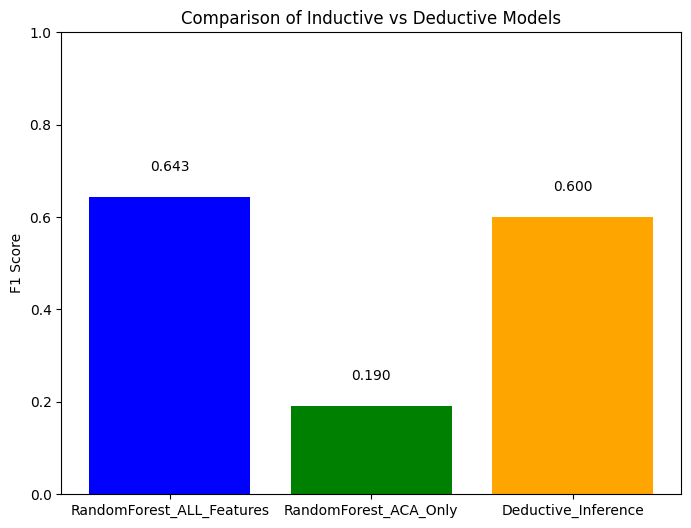

In [123]:
## create a bar plot comparing inductive vs deductive f1 scores for the three models: RandomForest_ALL_Features, RandomForest_ACA_Only, Deductive_Inference
model_names = list(MODEL_RESULTS.keys())
f1_scores = [MODEL_RESULTS[model]['f1_score'] for model in model_names]

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, f1_scores, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)
plt.title('Comparison of Inductive vs Deductive Models')
plt.ylabel('F1 Score')
for bar, score in zip(bars, f1_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.05, f'{score:.3f}', ha='center', va='bottom')
plt.savefig('plots/inductive_vs_deductive_f1_comparison.png')
plt.show()